# Is this Real? News Claim Verification Through Recognizing Textual Entailment

Goal : The Project aims to develop a news claim check detector utilizing multiple news articles and claims associated with the news articles. Our dataset will primarily consist of multiple claims to a news article having different labels of Entailment, Contradiction and Neutral. The final model will be able to classify a given claim to the above set of labels by referring to the abundance articles. The Project follows a Knowledge Based style which has the following components:

1/ Document Retrieval

2/ Sentence Retrieval

3/ Claim Verification

Summary - We perform **Sentence Retrieval** step by utilizing MiniLM Sentence Transformer to build embeddings and perform a cosine similarity to get a set of sentences for each claim above a Threshold. We fine-tune BERT and RoBERTa model using the above set of sentence-claim-label pairs and finally put together a small pipeline after comparing the model results.

Note - The **Document Retrieval** step has already been implemented to retrieve a npz file which contains document sparse matrix and its related metadata which has been used in this script.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras import regularizers
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
from sklearn.metrics import roc_curve, auc
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import ast

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/NLP Project/Data/article_claim_data.csv')

In [ ]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(df1['label'])
test_labels = label_encoder.transform(df1['label'])

In [ ]:
num_train_rows = 5994
df_train, df_test = train_test_split(df1, test_size=(1 - num_train_rows / len(df1)), random_state=42)

## **1.0 Sentence Retrieval**

In [ ]:
pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
df_train['entailed_sentences'] = None

In [ ]:
for index, row in df_train.iterrows():
    if row['entailed_sentences'] is None:
        document = row['Documents']
        claim = row['Claim']
        sentences = sent_tokenize(document)
        # Encode the sentences in the document using the sentence transformer model
        embeddings = sentence_transformer_model.encode(sentences)
        # Encode the claim using the sentence transformer model
        claim_embedding = sentence_transformer_model.encode(claim)
        retrieved_sentences = []
        # Compare each sentence with the claim using cosine similarity
        for sentence, embedding in zip(sentences, embeddings):
            cos_sim = util.cos_sim(claim_embedding, embedding)
            if cos_sim >= 0.4:
              retrieved_sentences.append(sentence)
        df_train.at[index, 'entailed_sentences'] = retrieved_sentences

In [ ]:
df_train.to_csv('article_claim_sentences.csv', index=False)

## **2.0 Claim Verification**

In [ ]:
df_with_sentences = pd.read_csv('/content/drive/MyDrive/NLP Project/Data/article_claim_sentences.csv')

In [ ]:
df_with_sentences['entailed_sentences'] = df_with_sentences['entailed_sentences'].apply(ast.literal_eval)
df_with_sentences = df_with_sentences.explode('entailed_sentences').reset_index(drop=True)

In [ ]:
df_final_data = df_with_sentences[['entailed_sentences','Claim','label']].copy()
df_final_data = df_final_data.dropna()

In [ ]:
df_train, df_test = train_test_split(df_final_data, test_size=15000, random_state=42)
df_train = df_train.head(num_train_rows)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
def plot_roc_curve(y_test_pred_prob, model):
  class_labels = {0: 'Contradiction', 1: 'Entailment', 2: 'Neutral'}

  fig = px.line(title=f'Receiver Operating Characteristic (ROC) Curve : {model} model ')

  for i in range(y_test_pred_prob.shape[1]):
      fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_test_pred_prob[:, i])
      roc_auc = auc(fpr, tpr)

      # Use custom class labels and colors
      fig.add_scatter(x=fpr, y=tpr, mode='lines', name=f'{class_labels[i]} (AUC={roc_auc:.2f})',
                      line=dict(color=px.colors.qualitative.Set1[i]))

  fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random')

  fig.update_layout(
      xaxis_title='False Positive Rate',
      yaxis_title='True Positive Rate',
      template='plotly_white',
      legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
  )
  fig.show()

In [ ]:
def print_confusion_matrix(y_test, y_pred, model):
  class_labels = ['Contradiction','Entailment','Neutral']
  mat = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(10,10))
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('True Label')
  plt.title(f'Confusion Matrix : {model} model')
  plt.ylabel('Predicted Label')

In [ ]:
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import torch
from torch.nn.functional import softmax
from transformers import AdamW, Trainer, TrainingArguments
from tensorflow.keras.utils import plot_model

In [ ]:
MAX_LENGTH = 512
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
model_history = {} # To store the history of the model
result_dict = [] # To store the results

In [ ]:
def get_input_and_attention(df, tokenizer):
  input_ids_list = []
  attention_masks_list = []
  token_type_ids_list = []
  for index, row in df.iterrows():
      sentence_a = row['entailed_sentences']
      sentence_b = row['Claim']

      inputs = tokenizer(sentence_a, sentence_b, padding='max_length', truncation=True, return_tensors='tf')

      input_ids = inputs['input_ids']
      attention_mask = inputs['attention_mask'] # this might change for other models
      token_type_ids = inputs.get('token_type_ids', None) #ignore this part

      input_ids_list.append(input_ids)
      attention_masks_list.append(attention_mask)
  input_ids = tf.concat(input_ids_list, axis=0) #converting list to tensor object
  attention_masks = tf.concat(attention_masks_list, axis=0)
  return input_ids, attention_masks

In [ ]:
def build_model(transformer, max_length=MAX_LENGTH):
    # Make transformer layers trainable
    for layer in transformer.layers:
        layer.trainable = True

    # GlorotNormal weight initializer with a specified seed for reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)

    # Input layers for input_ids and attention_mask
    input_ids_layer = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    input_attention_layer = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # Pass inputs through the transformer model
    output = transformer([input_ids_layer, input_attention_layer])

    # Extract [CLS] token and apply dropout
    cls_token = tf.keras.layers.Dropout(LAYER_DROPOUT)(output[0])

    # Fully connected layer with ReLU activation
    dense_output = tf.keras.layers.Dense(512, activation='relu', kernel_initializer=weight_initializer)(cls_token)

    # Output layer with softmax activation for classification
    output = tf.keras.layers.Dense(3, activation='softmax', kernel_initializer=weight_initializer)(dense_output)

    # Create the model with specified inputs and output
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    # Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

### **2.1 Fine-tuning BERT Model**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bertModel = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

In [ ]:
bert_model = build_model(bertModel)
print(bert_model)

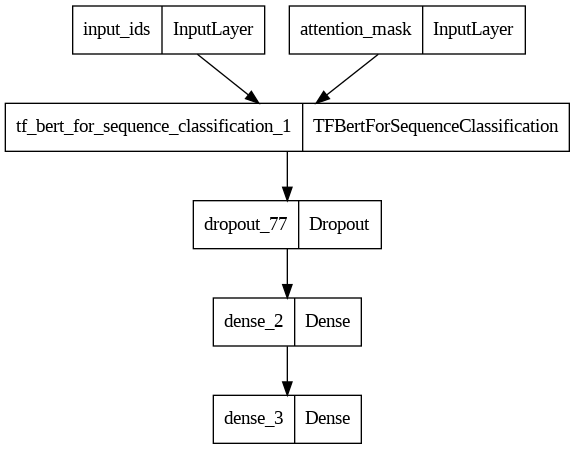

In [ ]:
plot_model(bert_model, to_file='bert_model.png')

In [ ]:
input_ids, attention_masks = get_input_and_attention(df_train, tokenizer)
input_ids_test, attention_masks_test = get_input_and_attention(df_test, tokenizer)

In [ ]:
labels = np.array(df_train['label'])
split_index = int(0.8 * len(labels))

input_ids_train, attention_masks_train = input_ids[:split_index], attention_masks[:split_index]
y_train = labels[:split_index]
input_ids_val, attention_masks_val = input_ids[split_index:], attention_masks[split_index:]
y_val = labels[split_index:]
y_test = np.array(df_test['label'])

In [ ]:
history_bert = bert_model.fit(
    x=  [input_ids_train, attention_masks_train],
    y= y_train,
    epochs=3,
    batch_size = 10,
    validation_data = ([input_ids_val, attention_masks_val], y_val),
)
model_history['BERT'] = history_bert.history

Epoch 1/3
800/800 [==============================] - 390s 436ms/step - loss: 0.5816 - accuracy: 0.7063 - val_loss: 1.9387 - val_accuracy: 0.3335
Epoch 2/3
800/800 [==============================] - 323s 403ms/step - loss: 0.3719 - accuracy: 0.7903 - val_loss: 1.8150 - val_accuracy: 0.3450
Epoch 3/3
800/800 [==============================] - 341s 426ms/step - loss: 0.2842 - accuracy: 0.8271 - val_loss: 2.8062 - val_accuracy: 0.3245


In [ ]:
bert_model._saved_model_inputs_spec = None
inp = {"input_ids": input_ids_train, "attention_mask": attention_masks_train}
bert_model._set_save_spec(inp)
tf.saved_model.save(bert_model, "/content/drive/MyDrive/NLP Project/Models/Bert")

In [ ]:
y_val_pred_probabilities = bert_model.predict([input_ids_test, attention_masks_test])
plot_roc_curve(y_val_pred_probabilities, 'BERT')
y_pred = y_val_pred_probabilities.argmax(axis=1)

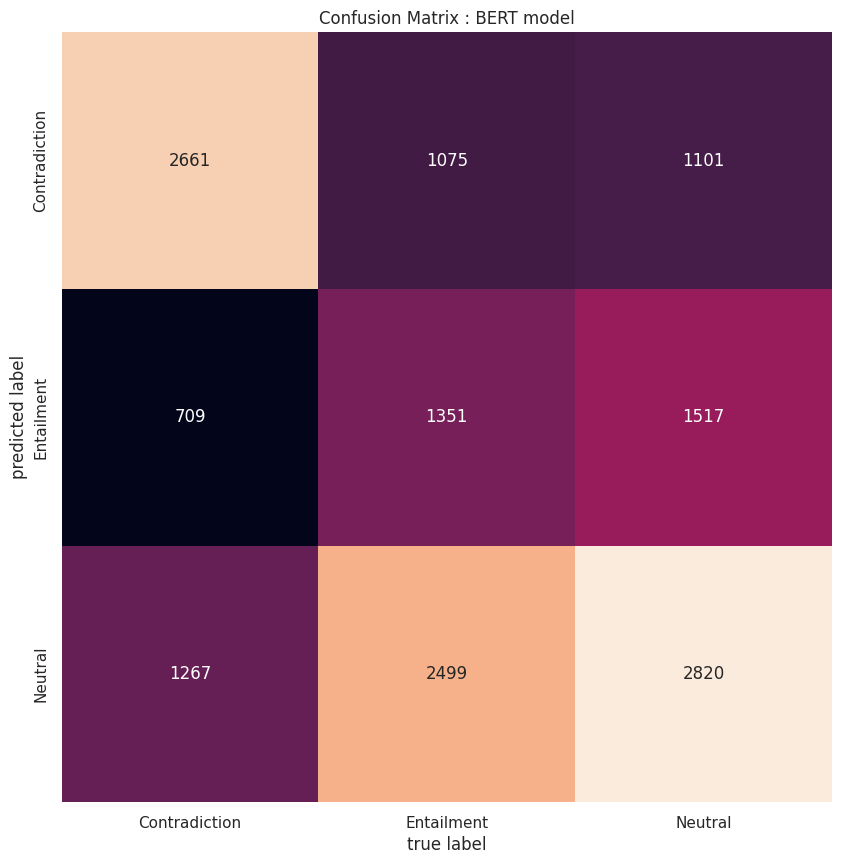

In [ ]:
print_confusion_matrix(y_test, y_pred, 'BERT')

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
micro_precision = precision_score(y_test, y_pred, average='micro')
macro_recall = recall_score(y_test, y_pred, average='macro')
micro_recall = recall_score(y_test, y_pred, average='micro')

In [ ]:
metrics_dict = {
    'accuracy': accuracy,
    'f1_score': f1,
    'macro_precision': macro_precision,
    'micro_precision': micro_precision,
    'macro_recall': macro_recall,
    'micro_recall': micro_recall
}
model_dict = {
    'model': 'BERT',
    'metrics': metrics_dict
}
result_dict.append(model_dict)

### **2.2 Fine-tuning RoBERTa Model**

In [ ]:
robert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = 3)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
input_ids, attention_masks = get_input_and_attention(df_train, robert_tokenizer)
input_ids_test, attention_masks_test = get_input_and_attention(df_test, robert_tokenizer)

In [ ]:
input_ids_train, attention_masks_train = input_ids[:split_index], attention_masks[:split_index]
y_train = labels[:split_index]
input_ids_val, attention_masks_val = input_ids[split_index:], attention_masks[split_index:]
y_val = labels[split_index:]

In [ ]:
roberta_model = build_model(roberta)
history_roberta = roberta_model.fit(
    x=  [input_ids_train, attention_masks_train],
    y=y_train,
    epochs=3,
    batch_size = 10,
    validation_data = ([input_ids_test, attention_masks_test], y_test),
)
model_history['RoBERTa'] = history_roberta.history

Epoch 1/3
800/800 [==============================] - 567s 668ms/step - loss: 0.7842 - accuracy: 0.5982 - val_loss: 1.2506 - val_accuracy: 0.4021
Epoch 2/3
800/800 [==============================] - 526s 658ms/step - loss: 0.4676 - accuracy: 0.7839 - val_loss: 1.5823 - val_accuracy: 0.4640
Epoch 3/3
800/800 [==============================] - 526s 658ms/step - loss: 0.2893 - accuracy: 0.8593 - val_loss: 2.1105 - val_accuracy: 0.4432


In [ ]:
y_val_pred_probabilities = roberta_model.predict([input_ids_test, attention_masks_test])
plot_roc_curve(y_val_pred_probabilities, 'RoBERTa')
y_pred = y_val_pred_probabilities.argmax(axis=1)

625/625 [==============================] - 219s 348ms/step


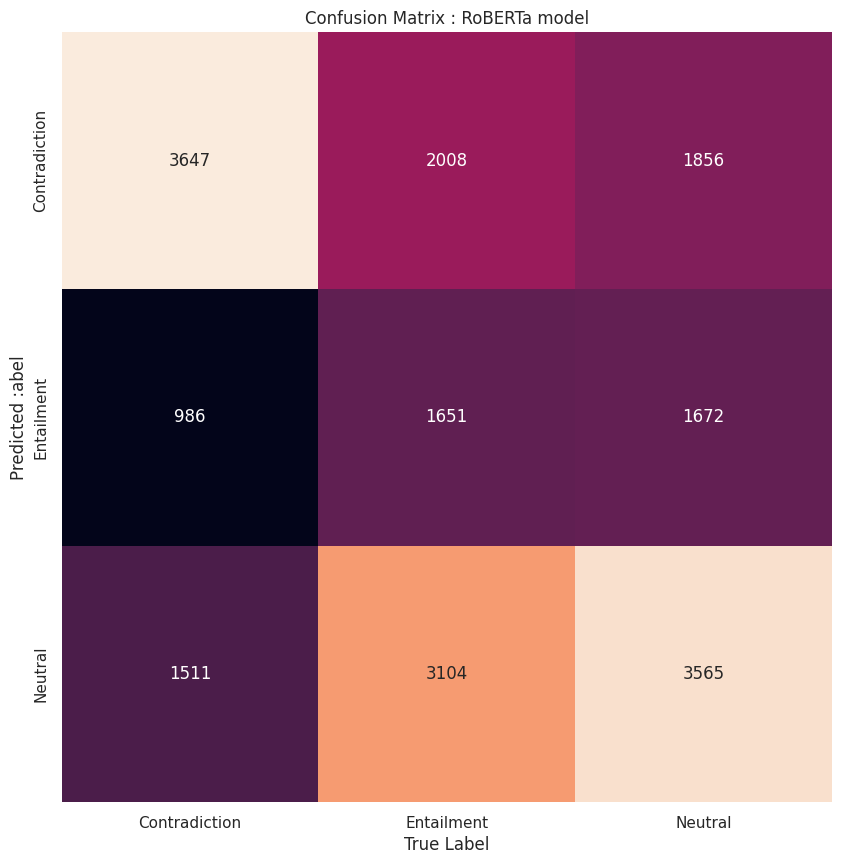

In [ ]:
print_confusion_matrix(y_test, y_pred, 'RoBERTa')

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
micro_precision = precision_score(y_test, y_pred, average='micro')
macro_recall = recall_score(y_test, y_pred, average='macro')
micro_recall = recall_score(y_test, y_pred, average='micro')

In [ ]:
result_dict = []
metrics_dict = {
    'accuracy': accuracy,
    'f1_score': f1,
    'macro_precision': macro_precision,
    'micro_precision': micro_precision,
    'macro_recall': macro_recall,
    'micro_recall': micro_recall
}
model_dict = {
    'model': 'RoBERTa',
    'metrics': metrics_dict
}
result_dict.append(model_dict)

In [ ]:
roberta_model._saved_model_inputs_spec = None
inp = {"input_ids": input_ids_train, "attention_mask": attention_masks_train}
roberta_model._set_save_spec(inp)
tf.saved_model.save(roberta_model, "/content/drive/MyDrive/NLP Project/Models/RoBERTa")

### **2.3 Fine-tuning XLNET Model**

In [ ]:
from transformers import TFXLNetForSequenceClassification, AutoTokenizer ,AutoModelForSequenceClassification

xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
XLNetModel =  AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased",
                                                           num_labels=3)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_ids, attention_masks = get_input_and_attention(df_train, tokenizer)
input_ids_test, attention_masks_test = get_input_and_attention(df_test, tokenizer)


input_ids_train, attention_masks_train = input_ids[:split_index], attention_masks[:split_index]
y_train = labels[:split_index]
input_ids_val, attention_masks_val = input_ids[split_index:], attention_masks[split_index:]
y_val = labels[split_index:]

In [ ]:
xlnet_model = build_model(XLNetModel)
history_xlnet = xlnet_model.fit(
    x=  [input_ids_train, attention_masks_train],
    y=y_train,
    epochs=3,
    batch_size = 10,
    validation_data = ([input_ids_test, attention_masks_test], y_test),
)
model_history['XLNET'] = history_xlnet.history

Epoch 1/3


800/800 [==============================] - 1125s 1s/step - loss: 1.1061 - accuracy: 0.3413 - val_loss: 1.0980 - val_accuracy: 0.3546
Epoch 2/3
800/800 [==============================] - 1095s 1s/step - loss: 1.1045 - accuracy: 0.3380 - val_loss: 1.0977 - val_accuracy: 0.3381
Epoch 3/3
800/800 [==============================] - 1096s 1s/step - loss: 1.1025 - accuracy: 0.3470 - val_loss: 1.0989 - val_accuracy: 0.3072


In [ ]:
y_val_pred_probabilities = xlnet_model.predict([input_ids_test, attention_masks_test])
plot_roc_curve(y_val_pred_probabilities, 'XLNET')
y_pred = y_val_pred_probabilities.argmax(axis=1)

625/625 [==============================] - 535s 854ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
micro_precision = precision_score(y_test, y_pred, average='micro')
macro_recall = recall_score(y_test, y_pred, average='macro')
micro_recall = recall_score(y_test, y_pred, average='micro')
metrics_dict = {
    'accuracy': accuracy,
    'f1_score': f1,
    'macro_precision': macro_precision,
    'micro_precision': micro_precision,
    'macro_recall': macro_recall,
    'micro_recall': micro_recall
}
model_dict = {
    'model': 'XLNET',
    'metrics': metrics_dict
}
result_dict.append(model_dict)

### **2.4 Model Results**

In [ ]:
df_results = pd.DataFrame(result_dict)
df_metrics = pd.json_normalize(df_results['metrics'])
df_final = pd.concat([df_results, df_metrics], axis=1)

In [ ]:
df_final.rename(columns = {'accuracy':'Accuracy','macro_precision':'Macro Precision','micro_recall':'Micro Recall','f1_score':'F1 Score'}, inplace=True)
df_final_results = pd.melt(df_final, id_vars=['model'], value_vars=['Accuracy', 'Macro Precision', 'Micro Recall','F1 Score'],
                    var_name='Metric', value_name='Score')
df_final_results.to_csv('model_scores.csv',index=False)

In [ ]:
df_final_results = pd.read_csv('model_scores.csv')

In [ ]:
color_sequence = ['red','darkblue']
fig = px.bar(df_final_results, x='Metric', y='Score',
             labels={'value': 'Score', 'model': 'Model'},
             color = 'model',
             text = 'Score',
             title='Metrics Comparison Across Models',
               color_discrete_sequence=color_sequence,
             barmode='group')


fig.update_layout(template='plotly_white')

fig.show()

In [ ]:
df_list = []
for model_name, history in model_history.items():
    for metric, values in history.items():
        for epoch, value in enumerate(values):
          df_list.append({'Model': model_name, 'Metric': metric, 'Epoch': epoch + 1, 'Value': value})

df_training = pd.DataFrame(df_list)
df_training = df_training.pivot_table(index=['Model', 'Epoch'], columns='Metric', values='Value').reset_index()
df_training.to_csv('model_history.csv', index=False)

In [ ]:
df_training = pd.read_csv('model_history.csv')


In [25]:
colors = {'BERT': 'maroon', 'RoBERTa': 'black'}
# Create separate figures for each model
for model in df_training['Model'].unique():
    model_data = df_training[df_training['Model'] == model]

    # Create a figure for accuracy
    fig_accuracy = go.Figure()

    # Plotting training and validation accuracy
    fig_accuracy.add_trace(go.Scatter(x=model_data['Epoch'], y=model_data['accuracy'],
                                      mode='lines+markers', name=f'{model} - Training Accuracy',
                                      line=dict(color='maroon')))

    fig_accuracy.add_trace(go.Scatter(x=model_data['Epoch'], y=model_data['val_accuracy'],
                                      mode='lines+markers', name=f'{model} - Validation Accuracy',
                                      line=dict(color='black')))

    # Update layout for accuracy figure
    fig_accuracy.update_layout(title=f'{model} - Training and Validation Accuracy',
                               xaxis_title='Epochs',
                               yaxis_title='Accuracy',
                               template='plotly_white',
                               legend=dict(x=1, y=1, traceorder='normal'))

    # Show the accuracy plot
    fig_accuracy.show()

    # Create a figure for loss
    fig_loss = go.Figure()

    # Plotting training and validation loss
    fig_loss.add_trace(go.Scatter(x=model_data['Epoch'], y=model_data['loss'],
                                  mode='lines+markers', name=f'{model} - Training Loss',
                                  line=dict(color='darkblue')))

    fig_loss.add_trace(go.Scatter(x=model_data['Epoch'], y=model_data['val_loss'],
                                  mode='lines+markers', name=f'{model} - Validation Loss',
                                  line=dict(color='black')))

    # Update layout for loss figure
    fig_loss.update_layout(title=f'{model} - Training and Validation Loss',
                           xaxis_title='Epochs',
                           yaxis_title='Loss',
                           template='plotly_white',
                           legend=dict(x=1, y=1, traceorder='normal'))

    # Show the loss plot
    fig_loss.show()

## **3.0 Claim Detection Pipeline**

#### 3.1 Document Retrieval

In [ ]:
pip install git+https://github.com/facebookresearch/DrQA.git

In [ ]:
import drqa.retriever
import json
retriever = drqa.retriever.get_class('tfidf')(tfidf_path='/content/drive/MyDrive/NLP Project/Data/documents-db-tfidf-ngram=2-hash=16777216-tokenizer=simple.npz')
claim = "A complaint has been filed against the judge with the State Commission for Judicial Conduct."
doc_ids, doc_scores = retriever.closest_docs(claim, k=5)

document_database_path = '/content/drive/MyDrive/NLP Project/Data/documents_db.json'
document_database = {}

with open(document_database_path, 'r', encoding='utf-8') as file:
    for doc_id, line in enumerate(file):
        document_database[doc_id] = line.strip()


documents = []
for doc_id, score in zip(doc_ids, doc_scores):
    document_str = document_database.get(int(doc_id) - 1)
    document_dict = json.loads(document_str)
    document_text = document_dict.get('text', '')
    documents.append(document_text)
    print(f"Document ID: {doc_id}, Score: {score}")
    print("\n" + "=" * 50 + "\n")


Document ID: 1508, Score: 154.36542063307706


Document ID: 4680, Score: 126.29220824548771


Document ID: 1, Score: 125.4206968017606


Document ID: 8831, Score: 82.57645731889181


Document ID: 4565, Score: 71.54424758225602




In [ ]:
print('The related document for Claim:')
print(df_with_sentences.iloc[0,0].lstrip())

The related document for Claim:
Whoever digs a pit will fall into it; if someone rolls a stone, it will roll back on them.If you set a trap for others, you will get caught in it yourself. If you roll a boulder down on others, it will crush you instead.Whoever digs a pit will fall into it, and a stone will come back on him who starts it rolling.He who digs a pit will fall into it, and whoever rolls a stone, it will come back on him.He who digs a pit will fall into it, And he who rolls a stone, it will come back on him.Whoso diggeth a pit shall fall therein: and he that rolleth a stone, it will return upon him.The one who digs a pit will fall into it, and whoever rolls a stone--it will come back on him.If you dig a pit, you will fall in; if you start a stone rolling, it will roll back on you.People who set traps for others get caught themselves. People who start landslides get crushed.The one who digs a pit will fall into it, and whoever rolls a stone-- it will come back on him.Whoever d

In [ ]:
# We can see that the document has been fetched.
documents[2]

'Whoever digs a pit will fall into it; if someone rolls a stone, it will roll back on them.If you set a trap for others, you will get caught in it yourself. If you roll a boulder down on others, it will crush you instead.Whoever digs a pit will fall into it, and a stone will come back on him who starts it rolling.He who digs a pit will fall into it, and whoever rolls a stone, it will come back on him.He who digs a pit will fall into it, And he who rolls a stone, it will come back on him.Whoso diggeth a pit shall fall therein: and he that rolleth a stone, it will return upon him.The one who digs a pit will fall into it, and whoever rolls a stone--it will come back on him.If you dig a pit, you will fall in; if you start a stone rolling, it will roll back on you.People who set traps for others get caught themselves. People who start landslides get crushed.The one who digs a pit will fall into it, and whoever rolls a stone-- it will come back on him.Whoever digs a pit will fall into it, an

#### 3.2 Sentence Retrieval

In [ ]:
claim_embedding = sentence_transformer_model.encode(claim)
top_sentences_per_document = []

In [ ]:
top_sentences_per_document = []

for doc in documents:
    sentences = sent_tokenize(doc)

    # Filter out short sentences
    filtered_sentences = [sentence for sentence in sentences if len(sentence) >= 20]

    # Encode the filtered sentences using the sentence transformer model
    embeddings = sentence_transformer_model.encode(filtered_sentences)
    retrieved_sentences = []

    # Compare each filtered sentence with the claim using cosine similarity
    for sentence, embedding in zip(filtered_sentences, embeddings):
        similarity_score = util.cos_sim(claim_embedding, embedding)
        retrieved_sentences.append((sentence, similarity_score))

    # Sort the retrieved sentences based on similarity score in descending order
    sorted_sentences = sorted(retrieved_sentences, key=lambda x: x[1], reverse=True)

    # Select the top 5 sentences with the highest similarity scores
    top_5_sentences = sorted_sentences[:5]
    top_sentences_per_document.append(top_5_sentences)


In [ ]:
top_sentences = [sentence for document_sentences in top_sentences_per_document for sentence, _ in document_sentences]
for i in range(5):
  print(f"Retrieved Sentence {i}:")
  print(top_sentences[i])

Retrieved Sentence 0:
The Ethics Commission administers and enforces the Conflicts Law.
Retrieved Sentence 1:
The Ethics Commission “has the power to undertake investigations and hold hearings regarding alleged violations of the Conflicts Law” and issue advisory opinions regarding whether a certain set of facts could, in the Commission’s opinion, constitute possible violations of the Conflicts Law or any other code, rule, or regulation.
Retrieved Sentence 2:
441 442 443 444 445  Two of these complaints were received on September 11, 2013, and an additional complaint was received on September 13, 2013.
Retrieved Sentence 3:
He served as a Law Clerk for U.S. District Judge Hector M. Laffitte of the District of Puerto Rico.
Retrieved Sentence 4:
For example, the Chief Ethics Officer can report matters to the Governor that should not be reported to the Chief Counsel in the first instance.


#### 3.3 Claim Verification

In [ ]:
predictions = []
for sentence in top_sentences:
  input_ids_list = []
  attention_masks_list = []
  token_type_ids_list = []
  inputs = tokenizer(sentence, claim, padding='max_length', truncation=True, return_tensors='tf')
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  input_ids_list.append(input_ids)
  attention_masks_list.append(attention_mask)
  input_ids = tf.concat(input_ids_list, axis=0)
  attention_masks = tf.concat(attention_masks_list, axis=0)
  prediction = bert_model.predict([input_ids, attention_masks]).argmax(axis=1)
  predictions.append(prediction)

In [ ]:
label = max(predictions, key=predictions.count) # A frequency/voting count of the model predictions to get a final prediction
if label == 0:
    print("The Claim Predicted is : Contradiction")
elif label == 1:
    print("The Claim Predicted is : Entailment")
elif label == 2:
    print("The Claim Predicted is : Neutral")

The Claim Predicted is : Neutral
